# CEM Notebook Example - Simulated Linear Dataset
Here we provide a notebook example illustrating the usage of the CEM package with simulated dataset.

In [ ]:
from CEM.balance import balance
from CEM.cem import cem
from CEM.data_generation import data_generation
from CEM.inference import inference
from CEM.sensitivity_analysis import *

## 1. Data preperation
The first step to prepare our dataset, and we can generate a simulated dataset with `data_generation` function, in which the result variable *Y* is linearly dependent with control variables *X* and treatment variable *T*.


In [ ]:
df = data_generation(n=10000, # sample size
                     p=0.2,   # P(T=1)
                     att=3,   # True average treatment effect on treated
                     x_cont=[0,1,6], # Generate 6 continuous variables X following the normal distribution N(0, 1).
                     x_cate=[2, 4, 4], # Generate 3 catigorical variables X with 2, 4, 4 categories respectively.
                     con_x=[(0, 3), (1, -2), (2, 1), (6, 2.5), (8, 1.5)] # X1, X2, X3, X7, X9 are confounders and
                     )                                                   # their effect on T are 3, -2, 1, 2.5, 1.5 resectively.

df.head()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,T,Y
0,-1.127227,-1.581226,-0.655666,-0.190080,0.931387,-0.588746,0.0,0.0,3.0,1,-3.788854
1,-0.350291,-0.696851,1.826706,-0.755002,1.492192,0.298964,0.0,3.0,3.0,0,10.432177
2,-1.107880,-0.004073,-1.816644,-0.256589,0.564622,-0.383192,0.0,2.0,2.0,0,13.527538
3,-1.439544,0.115199,-0.124043,1.287961,0.178038,0.965040,0.0,0.0,1.0,0,2.413546
4,0.397636,-0.012467,0.641735,-1.049706,-0.581218,-1.432816,0.0,0.0,1.0,1,-4.718393


## 2. Coarsened Exact Matching (CEM)
**CEM** is a data preprocessing algorithm in causal inference that has a broad applicability to **observational data**.  

When conducting CEM, each sample is represented by confounder properties coarsened to discrete values using a coarsening or binning strategy. Thus each sample is given a “**BIN Signature**” and samples with **exactly the same** signature will be matched in the same group.

In this package, you can also conduct 1-k matching based on the CEM. Inspired by the K Nearest Neighbor Algorithm, in the same strata, a treated sample will be matched with k controled samples having nearest distance or propensity score with it.

With CEM, you can construct your observational data into 'quasi' experimental data easily, mitigating the model dependency, bias, and inefficiency of your estimation of the treatment effect (Ho, Imai, King, & Stuart 2007).

**Reference**

- Daniel Ho, Kosuke Imai, Gary King, and Elizabeth Stuart. (2007). “Matching as Nonparametric Preprocessing for Reducing Model Dependence in Parametric Causal Inference.” Political Analysis, 15, Pp. 199–236. Copy at https://tinyurl.com/y4xtv32s

Firstly you should create your own `cem` , giving it your dataframe, column names of confounders, continuous confounders, result variable **Y** and treatment variable **T**.

In [ ]:
confounder_cols = ['X1','X2','X3','X7', 'X9']
cont_confounder_cols = ['X1','X2','X3']
my_cem = cem(df = df, # dataframe to be matched
             confounder_cols = confounder_cols, # list of confounders' column names
             cont_confounder_cols = cont_confounder_cols, # list of continuous confounders' column names
             col_y = 'Y', # column name of result variable
             col_t = 'T' # column name of treatment variable
             )

The summary of the simulated dataframe is as follows.   
 Before matching the ***estimated ATT*** (Average Treatment Effect on Treated) is 1.0085, which is far from the ***true ATT*** 3.0.

In [ ]:
my_cem.summary()

Descriptive Statistics of the dataframe:

                X1           X2           X3           X4           X5  \
count  10,000.0000  10,000.0000  10,000.0000  10,000.0000  10,000.0000   
mean       -0.0160       0.0213      -0.0013       0.0001      -0.0144   
std         0.9963       1.0065       0.9986       0.9955       0.9841   
min        -3.5670      -4.2668      -4.7132      -4.0806      -3.4952   
25%        -0.6865      -0.6595      -0.6691      -0.6720      -0.6779   
50%        -0.0231       0.0113      -0.0048      -0.0038      -0.0129   
75%         0.6568       0.7026       0.6661       0.6730       0.6519   
max         3.6061       3.7632       4.1706       3.9502       3.7476   

                X6           X7           X8           X9            T  \
count  10,000.0000  10,000.0000  10,000.0000  10,000.0000  10,000.0000   
mean       -0.0016       0.4954       1.5062       1.4953       0.1533   
std         1.0056       0.5000       1.1230       1.1172       0.360

Then we can try matching your dataset using `match` function with default parameters.  
After the default coarsened exact matching, 82.84% treated samples are matched.

In [ ]:
my_cem.match()

Matching result

    all  matched  propotion
0  8467     3338     0.3942
1  1533     1270     0.8284



,X1,X2,X3,X4,X5,X6,X7,X8,X9,T,Y,coarsen_X1,coarsen_X2,coarsen_X3,weight
0,-1.127227,-1.581226,-0.655666,-0.190080,0.931387,-0.588746,0.0,0.0,3.0,1,-3.788854,5,5,6,1.000000
4,0.397636,-0.012467,0.641735,-1.049706,-0.581218,-1.432816,0.0,0.0,1.0,1,-4.718393,8,7,9,1.000000
9,0.365122,-0.678249,-0.319547,0.179332,-0.549880,-0.816250,0.0,1.0,1.0,0,-4.419820,8,6,7,0.716822
11,1.114368,-0.283875,0.186455,1.172719,-1.192766,-1.359875,1.0,3.0,3.0,1,-1.742256,9,7,8,1.000000
12,-0.587288,-0.496063,0.749960,1.325562,0.297028,-0.783982,1.0,0.0,1.0,1,-4.035459,6,7,9,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9994,0.827941,0.662309,0.896298,-0.410935,0.091587,-1.664665,1.0,2.0,1.0,0,6.630141,9,9,9,0.525669
9995,0.469805,0.819588,-1.637660,1.694495,0.254168,-1.689911,0.0,1.0,2.0,0,-0.674841,8,9,5,1.314173
9996,0.377473,0.059204,-1.353984,0.444869,-0.449252,-1.192192,0.0,3.0,2.0,0,6.292132,8,8,5,2.628346
9998,-0.166134,-1.643278,-0.198524,0.297944,1.239472,-0.846091,1.0,1.0,3.0,0,-3.036967,7,4,7,0.657087


## 3. Balance Checking
When we finish the coarsened exact matching, it is necessary to evaluate the quality of the matching
with balance checking methods.  
When the covariate balance is achieved, the resulting effect estimate is less sensitive to model misspecification and ideally close to true treatment effect (Greifer, 2023).  

---


The imbalance checking methods provided include:


*   'L1': Calculate and return the L1 imbalance score.
*   'smd': Print the standardized mean difference summary table and plots of confounders.
* 'ks': Plot Kolmogorov-Smirnov Statistics of confounders before and after matching.
* 'density': Return density plots of confounders before and after matching.
* 'ecdf': Return empirical cumulative density plots of confounders before and after matching.

**Reference**

- Greifer N (2023). cobalt: Covariate Balance Tables and Plots. https://github.com/ngreifer/cobalt.
        
        
        


Firstly you should create your own `balance` instance, giving it your matched dataframe, original dataframe, column names of confounders, continuous confounders, result variable ***Y*** and treatment variable ***T***.

Let's check the L1 imbalance score after CEM with default coarsen parameters.

In [ ]:
my_balance = balance(df_match = my_cem.matched_df, # matched dataframe
                     df_all = my_cem.df, # original dataframe
                     confounder_cols = my_cem.confounder_cols, # list of column names of confounders
                     cont_confounder_cols = my_cem.cont_confounder_cols, # list of column names of continuous confounders
                     col_y = 'Y', # column name of result variable
                     col_t = 'T') # column name of treatment variable

l1_before, l1_after = my_balance.balance_assessing(method = 'L1')

L1 imbalance score before matching: 0.6316

L1 imbalance score after matching: 0.2895



Moreover, we can customize our coarsen schema to optimize our matching result.  

---

**Method 1:**
You can input a schema dictionary indicating how to coarsen each continuous confounders ***X*** if you have a thorough understanding on your dataset.

The following cutting method can be chosen.
* `cut`: Bin values into discrete intervals with the same length.
* `qcut`: Discretize variable into equal-sized buckets based on rank or based on sample quantiles.
* `struges`: Bin values into discrete intervals with the same length k according to the Sturges' rule.

**Method 2:**
You can also use the `tunning_schema` function to help you tune the coarsen schema automatically.  
The matched result with a suitable coarsen schema will have smaller L1 imbalance score and more matched samples.


Here we show the example of `tunning_schema`. Comparing with default coarsen schema, the L1 imbalance score after matching with tuned schema decreases from 0.2895 to 0.2591.

Matching result

    all  matched  propotion
0  8467     5763     0.6806
1  1533     1431     0.9335

L1 imbalance score before matching: 0.434

L1 imbalance score after matching: 0.2591

-------------------------

SMD Result

Balance measures

    Treated Mean  Control Mean     SMD Variance Ratio SMD.Threshold(<0.1)  \
X1        0.1755        0.0924  0.0956         0.9329            Balanced   
X2       -0.1462       -0.1407 -0.0062         1.0103            Balanced   
X3        0.1375        0.1331  0.0049         0.9924            Balanced   
X7        0.5304        0.5304  0.0000              .            Balanced   
X9        1.6660        1.6660 -0.0000              .            Balanced   

   Var.Threshold(<2)  
X1          Balanced  
X2          Balanced  
X3          Balanced  
X7                 .  
X9                 .  

-------------------------
Balance tally for SMD

                     count
SMD.Threshold(<0.1)       
Balanced                 5

----------------------

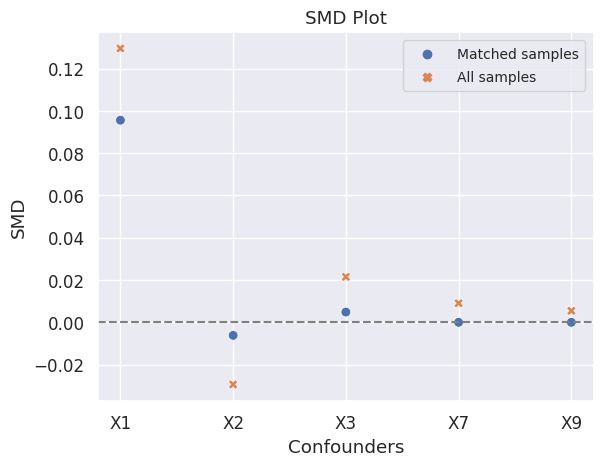

-------------------------

KS Result



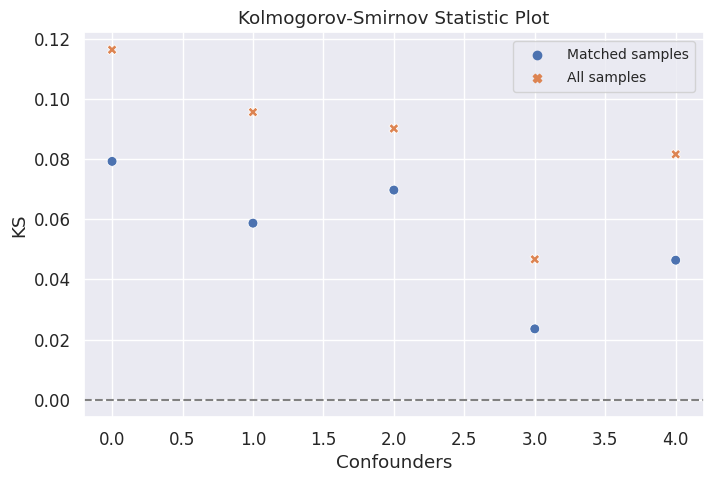

-------------------------

Density Plot



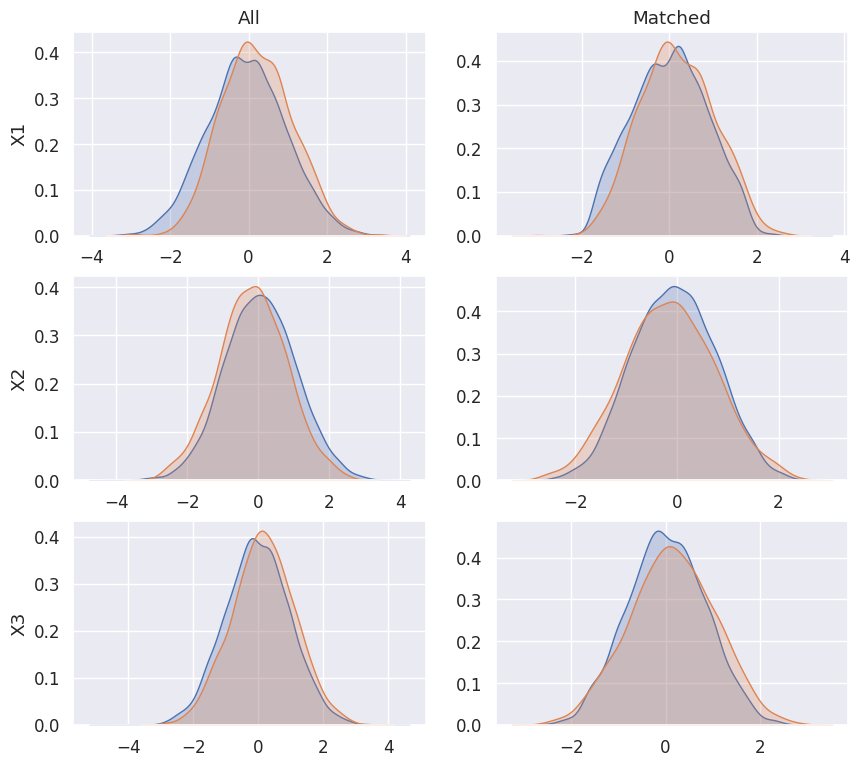

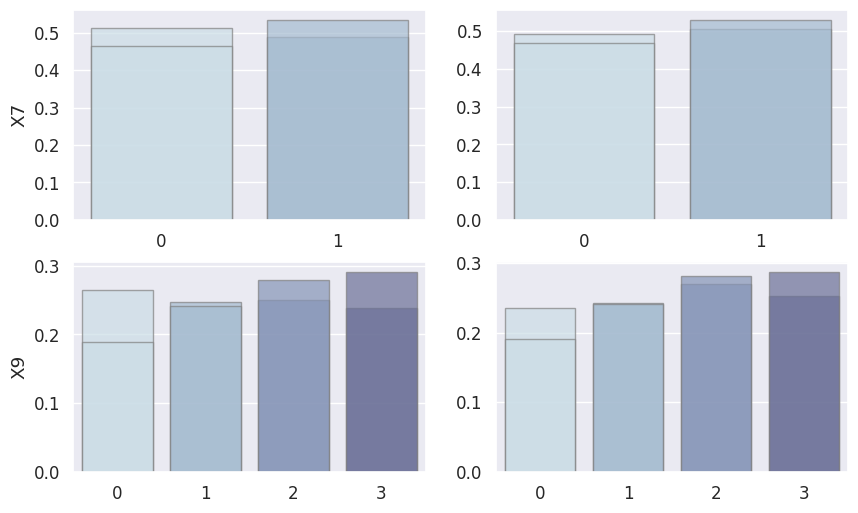

-------------------------

ECDF Plot



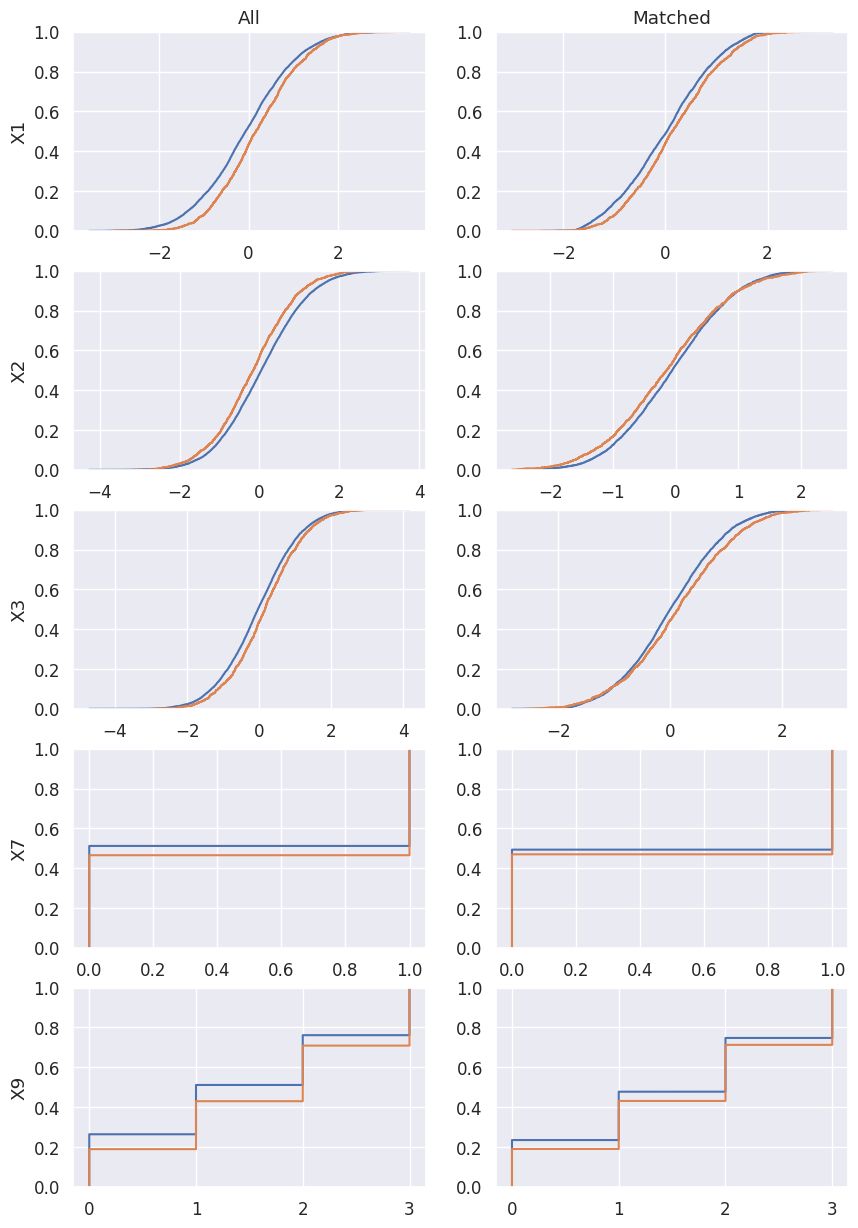

In [ ]:
l1, schema = my_cem.tunning_schema(step = 4)
my_cem.match(schema = schema)
my_balance = balance(my_cem.matched_df, my_cem.df, my_cem.confounder_cols, my_cem.cont_confounder_cols)
my_balance.balance_assessing(method = 'all')

## 4. Treatment Effect Inference
After conducting the coarsened exact matching and imbalance checking, we can estimate the ***average treatment effect ATT*** and ***heterogeneous treatment effect HTE*** with statistical inference methods.


---

* Ordinal least square linear regression method `linear_att` and weighted least square linear regression method `weighted_linear_att` are provided for the ATT estimation.
$$Y = \hat{\theta}T + \hat{\beta}X + ϵ \tag{1}$$
$$\widehat{ATT} = \hat{\theta} \tag{2}$$

* Linear double machine learning method (Chernozhukov et al. 2017) `linear_dml_hte` is provided for the HTE estimation.
$$Y^{\bot X} = Y - \hat{\beta_1}X \tag{1}$$
$$T^{\bot X} = T - \hat{\beta_2}X \tag{2}$$\
$$Y_i^{\bot X} = \widehat{\theta(X_i)}T^{\bot X} + ϵ \tag{3}$$
$$\widehat{HTE} = \widehat{\theta(X_i)} \tag{4}$$
$$\widehat{CATE} = E{\widehat{\theta(X_i)}} \tag{5}$$

**Reference**
- Chernozhukov, V., Chetverikov, D., Demirer, M., Duflo, E., Hansen, C., Newey, W., & Robins, J. (2017). Double/debiased machine learning for treatment and causal parameters.

Firstly you should create your own `inference` instance, giving it your matched dataframe,  column names of result variable ***Y***, treatment variable ***T***, control variables ***X***, and confounders.

With the weighted linear regression method and linear double machine learning method, the estimated ATT and CATE are 2.8786, 3.0653 respectively, which are much better than 1.0085.

In [ ]:
my_inf = inference(df = my_cem.matched_df, # matched dataframe
                   col_y = 'Y', # column name of result variable
                   col_t = 'T', # column name of treatment variable
                   col_x = ['X4', 'X5', 'X6', 'X8'], # list of column names of control variables, please be noted that confounders should not be included in this list
                   confounder_cols = my_cem.confounder_cols) # list of column names of confounders

att = my_inf.weighted_linear_att()
print(f'att: {round(att, 4)}')
cate, hte, r2 = my_inf.linear_dml_hte()
print(f'cate: {round(cate, 4)}, r2:{round(r2, 4)}')

                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.704
Model:                            WLS   Adj. R-squared:                  0.704
Method:                 Least Squares   F-statistic:                     3420.
Date:                Fri, 21 Jul 2023   Prob (F-statistic):               0.00
Time:                        10:55:56   Log-Likelihood:                -22394.
No. Observations:                7194   AIC:                         4.480e+04
Df Residuals:                    7188   BIC:                         4.484e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.5359      0.102    -24.891      0.0

## 5. Sensitivity Analysis
When we conduct causal inference to the observational data, the most important assumption is that there is no unobserved confounding.  
Therefore, after finishing the treatment effect estimation, investigators are advised to conduct the sensitivity analysis to **examine how fragile a result is against the possibility of unobserved confounders** (Cinelli, Hazlett, 2019).  
In other words, we should examine how strong the effect of unobserved confounders should be to erase the treatment effect estimated.


---
Two methods are provided in our package, including  **Omitted variable bias** based sensitivity analysis method (Cinelli, Hazlett, 2020) and **Wilcoxon's  signed rank test** based sensitivity analysis method (Rosenbaum, 2015).
* **Omitted variable bias** based sensitivity analysis method: This method can be used if your result variable ***Y*** is linearly dependent with ***X*** and ***T***.
* **Wilcoxon's  signed rank test** based sensitivity analysis method: It is suitable for 1-1 matched dataset, which means that only 1 untreated sample are matched with each treated sample, and this can be achieved by setting `k2k_ratio = 1` in the `match` step.

**Reference**

- Cinelli, C., & Hazlett, C. (2020). Making Sense of Sensitivity: Extending Omitted Variable Bias. Journal of the Royal Statistical Society Series B: Statistical Methodology, 82(1), 39–67. https://doi.org/10.1111/rssb.12348

- Rosenbaum, P. R. (2005). Sensitivity analysis in observational studies. Encyclopedia of statistics in behavioral science.



### 5.1 Omitted variable bias based sensitivity analysis

In the following example, we choose X2 as our benchmark variable. The analysis result gives us the following informations:

*   **Robustness Value (RV)**:  
It provides a convenient reference point to assess the overall robustness of a coefficient to unobserved confounders. If the confounder's association to the treatment $R_{Y\sim Z|T, X}^2$ and to
the outcome $R_{Z\sim T|X}^2$ are both assumed to be less than the ***RV***, then such confounders cannot “explain away” the observed effect.

*   **Contour Line**:  
The points on the same contour line has the same adjusted estimated ATT. The contour line helps us to know the value of the adjusted estimated ATT when $R_{Y\sim Z|T, X}^2 = a$ and $R_{Z\sim T|X}^2 = b$.

* **Bound the strength of the hidden confounder using observed covariate**:  
We can choose an observed confounder $X_j$ as a benchmark, and check the adjusted estimated ATT when
$$\frac{R_{Y\sim Z|T, X_{-j}}^2}{R_{Y\sim X_j|T, X_{-j}}^2} = K_Y \tag{1}$$
$$\frac{R_{T\sim Z|X_{-j}}^2}{R_{T\sim X_j|X_{-j}}^2} = K_T \tag{2}$$






,K_t,K_y,R2_Y,R2_T,Adjusted att
0,0.2,0.2,0.3049,0.0016,2.9722
0,0.2,0.5,0.7580,0.0016,2.8609
0,0.5,0.2,0.3077,0.0040,2.9328
0,0.5,0.5,0.7624,0.0040,2.7542


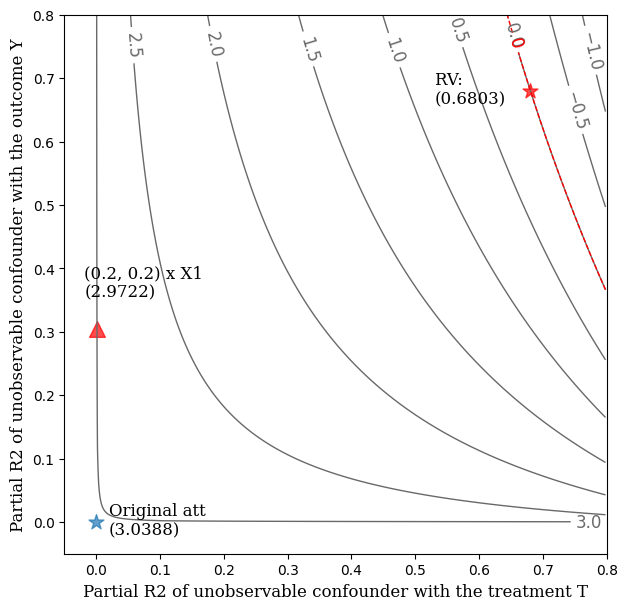

In [ ]:
import statsmodels.api as sm

X = sm.add_constant(my_cem.matched_df[[my_cem.col_t] + [f'X{i}' for i in range(1, 10)]])
y = np.asarray(my_cem.matched_df[my_cem.col_y])
model = sm.WLS(y.astype(float), X.astype(float), weights=1)

my_ovb = ovb(model=model, bench_variable='X1', k_t = [0.2, 0.5], k_y=[0.2, 0.5],  measure = 'att')
my_ovb.plot_result()

### 5.2 Wilcoxon's signed rank test based sensitivity analysis

Wilcoxon's signed rank test based sensitivity analysis imagines that in the population before matching, all samples are assigned to treatment or control independently with unknown probabilities. However, two samples  with the same observed confounders
may nonetheless differ in terms of unobserved confounders, so that one sample has an odds of treatment that is up to $\Gamma$ ≥ 1 times greater than the odds for another sample.

The sensitivity analysis asks how large the $\Gamma$ should be to erase the treatment effect estimated.

Wilcoxon's signed rank test based sensitivity analysis is suitable for 1-1 matched dataset, therefore 1-1 matching needs to be conducted firstly. You can implement it simply by setting `k2k_ratio = 1`, and here we choose the propensity score to measure the similarity by setting `dist = 'psm'`.

In [ ]:
my_cem_k2k = cem(df, confounder_cols, cont_confounder_cols)
my_cem_k2k.match(k2k_ratio = 1, dist = 'psm')

Matching result

    all  matched  propotion
0  8467     1270     0.1500
1  1533     1270     0.8284



,X1,X2,X3,X4,X5,X6,X7,X8,X9,T,Y,coarsen_X1,coarsen_X2,coarsen_X3,score
9303,-1.450899,-1.357451,0.665599,0.790244,0.783342,-2.295657,0.0,3.0,0.0,1,5.244102,4,5,9,0.347542
9422,-1.445416,-1.167397,0.786925,0.457915,1.080332,-1.155590,0.0,2.0,0.0,0,5.025484,4,5,9,0.335796
9333,-0.857453,-2.138422,-0.013322,-1.756193,-1.646578,1.952297,0.0,2.0,0.0,1,10.330124,5,3,7,0.504936
9798,-0.836889,-2.132313,-0.294933,0.749229,0.749477,0.833394,0.0,1.0,0.0,0,1.849120,5,3,7,0.495064
3000,-1.014093,-1.164439,1.678720,-0.461548,-0.064063,-0.312445,0.0,3.0,0.0,1,11.359059,5,5,10,0.508624
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4679,1.809788,-0.364098,0.278989,0.126101,-0.181383,-1.002701,1.0,3.0,3.0,0,1.893394,11,7,8,0.203118
7743,1.747734,0.527945,-0.870294,-0.766506,0.840439,0.213907,1.0,0.0,3.0,1,8.364442,11,8,6,0.505338
568,1.896559,0.276895,-0.904587,-0.007944,-0.241724,0.935443,1.0,3.0,3.0,0,13.154511,11,8,6,0.494654
8920,1.716834,0.752530,0.189902,-1.460253,-0.657810,0.855391,1.0,0.0,3.0,1,4.900757,11,9,8,0.336930


The `wilcoxon` class function can give you a result table, which shows you the p-value intervals under each $\Gamma$.

In the following example, when $\Gamma$ = 4.25, the upper bound of the p-value's interval is greater than 0.05, which means that in this situation, we don’t have 95% confidence to reject the null hypothesis that the treatment is randomly assigned. In other words, when $\Gamma$ = 4.25 the estimated ATT will be explained away by unovserved confounders.

In [ ]:
my_sen = wilcoxon(df=my_cem_k2k.matched_df, pair = my_cem_k2k.pair)
wilcoxon_df = my_sen.result([1, 2, 3, 4, 4.25, 5])

       lower_p  upper_p
gamma                  
1.00       0.0   0.0000
2.00       0.0   0.0000
3.00       0.0   0.0000
4.00       0.0   0.0112
4.25       0.0   0.0575
5.00       0.0   0.6223
The estimated ATT result is not reliable if there exists an unobservable confounder which makes the magnitude of probability
that a single subject will be interfered with is 4.25 times higher than that of the other subject.
